In [1]:
import cv2
import os
import numpy as np
import sys

Load the necessary libraries


## Files


In [56]:
root = 'MoodRecognition/'
haar_cascade_path = 'haarcascade_frontalface_default.xml'
path = 'images'
raw_path = 'raw_images'
moods = os.listdir(path)
face_path = 'faces'
raw_face = 'raw_faces'
faces = os.listdir(face_path)

Set the correct variables for preprocessing, training, and testing uses.


In [3]:
def video_detect(video_files, save_folder):
    print("Found",len(video_files))
    face_cascade = cv2.CascadeClassifier(haar_cascade_path)
    j = 1 #counter of saved images
    
    for file in video_files:
        print("Extracting",file)
        video = cv2.VideoCapture(file)
        if not video.isOpened():
            print(f"Error: Could not open video file {file}")
            continue
        i = 0
        while True:
            i += 1
            ret, frame = video.read()
            if i!=2: continue
            i = 0
            if not ret:
                break
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            faces = face_cascade.detectMultiScale(gray, 1.5, 5)

            for (x, y, w, h) in faces:
                roi_gray = gray[y:y + h, x:x + w]
                roi = cv2.resize(roi_gray, (224,224), interpolation=cv2.INTER_LINEAR)
                cv2.imwrite(os.path.join(save_folder, f'image_{j}.jpg'), roi)
                j += 1
        video.release()

In [4]:
for mood in moods:
  print(mood)
  files = os.listdir(f'{raw_path}/{mood}')
  video_files = [os.path.join(raw_path,mood,file) for file in files if file.endswith(('.mp4', '.avi', '.mov'))]
  video_detect(video_files,f'{path}/{mood}')
    

Angry
Found 1
Extracting raw_images\Angry\angry.mp4
Confused
Found 1
Extracting raw_images\Confused\confused.mp4
Happy
Found 1
Extracting raw_images\Happy\happy.mp4
Sad
Found 2
Extracting raw_images\Sad\sad.mp4
Extracting raw_images\Sad\sad1.mp4


I have videos as my inputs. Every one of three frames will only be extracted since adjacent frames are similar. This will be saved in a new folder in grayscale and appropriate size.


## Recognition


In [5]:
def read_images(path, sz=None):
  c = 0
  X, y = [], []

  for dirname, dirnames, filenames in os.walk(path):
    for subdirname in dirnames:
      subject_path = os.path.join(dirname, subdirname)
      for filename in os.listdir(subject_path):
        try:
          if(filename == ".directory"):
            continue
          filepath = os.path.join(subject_path, filename)
          im = cv2.imread(os.path.join(subject_path, filename), cv2.IMREAD_GRAYSCALE)

          # Resize the images to the prescribed size
          if (sz is not None):
            im = cv2.resize(im, (224,224))

          X.append(np.asarray(im, dtype=np.uint8))
          y.append(c)

        except IOError as e:
          print(f"I/O Error({e.errno}): {e.strerror}")
        except:
          print("Unexpected error:", sys.exc_info()[0])
          raise
      c = c+1
  return [X, y]

In [58]:
def train(path):
  if len(sys.argv) < 2:
    print("USAGE: facerec_demo.py </path/to/images> [</path/to/store/images/at>]")
    sys.exit()

  [X,y] = read_images(path)
  y = np.asarray(y, dtype=np.int32)
  return X, y
  

In [62]:
X, y = train(path)

In [63]:
mood_model = cv2.face.LBPHFaceRecognizer_create()
mood_model.train(X, y)

Lets train the Mood Model first. This contains 4 moods such as happy, sad, confused, and angry. LBPHFaceRecognizer_create allows us to create a model that specializes in recognizing faces.


In [64]:
mood_model.write('mood_model.yml')

Save the model


In [68]:
face_model = cv2.face.LBPHFaceRecognizer_create()
X, y = train(face_path)
face_model.train(X, y)

Next, train the Face Model which will evaluate whether the face is me or another person.


In [60]:
face_model.write('face_model.yml')

Save the face model


## Testing


In [65]:
def face_rec(face_model, mood_model):
  camera = cv2.VideoCapture(0)
  face_cascade = cv2.CascadeClassifier(haar_cascade_path)

  while True:
    ret, img = camera.read()
    if not ret:
      break
    img = cv2.flip(img,1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.8, 10)

    for (x, y, w, h) in faces:
      try:
        roi = cv2.resize(gray[y:y + h, x:x + w], (224, 224), interpolation=cv2.INTER_LINEAR)

        if face_model.predict(roi)[0] == 0: #If it is my face (y=0)
          params = mood_model.predict(roi) #Predicts my expression
          label = moods[params[0]]
        else:
          label = 'Unknown'
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img, label, (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
      except:
        continue

    cv2.imshow("camera", img)
    if cv2.waitKey(1) & 0xFF == ord("q"):
      break

  camera.release()
  cv2.destroyAllWindows()

In [99]:
mood_model = cv2.face.EigenFaceRecognizer_create()
mood_model.read('mood_model.yml')

In [ ]:
face_model = cv2.face.EigenFaceRecognizer_create()
face_model.read('face_model.yml')

Load both models so we can test it with our camera


In [66]:
for mood in moods[::-1]:
    img_path = f'images/{mood}/image_69.jpg'
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.flip(img,1)
    roi = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
    param = mood_model.predict(roi)
    print("Prediction:",moods[param[0]],"\tActual:",mood)

Prediction: Sad 	Actual: Sad
Prediction: Happy 	Actual: Happy
Prediction: Confused 	Actual: Confused
Prediction: Angry 	Actual: Angry


Upon testing the Mood Model with the training images, it appears that it can detect all moods pretty well. Its predictions are correct


In [69]:
face_rec(face_model, mood_model)

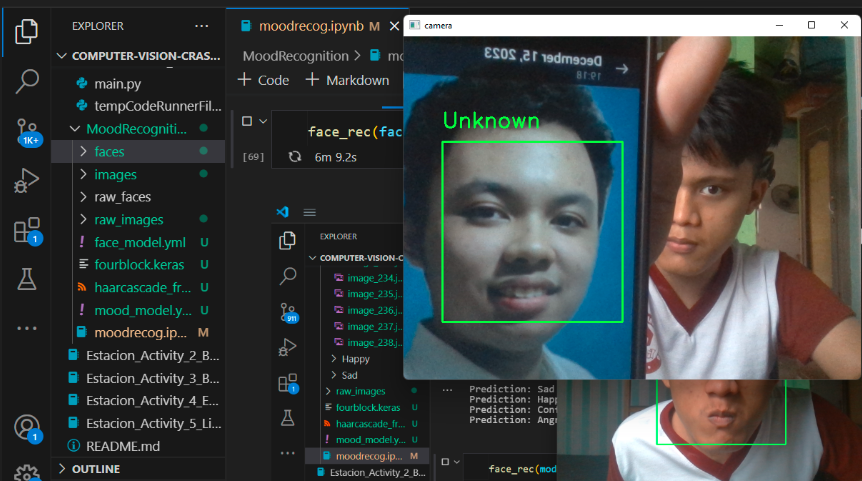

I showed to the camera a face of my classmate and the Face Model predicted it as unknown. The model is correct since it is not my face.


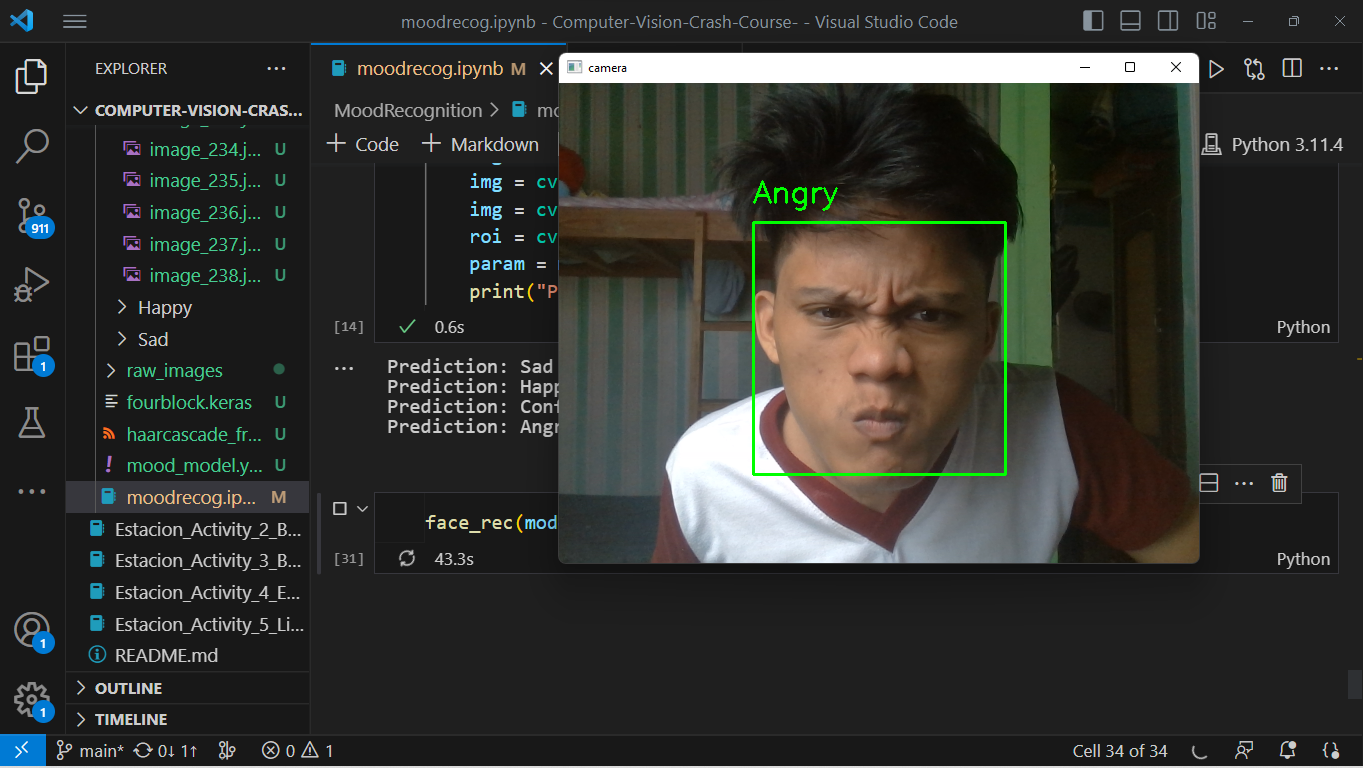

Here is my angry face. It is recognized as angry by the Mood Model. The model is correct.


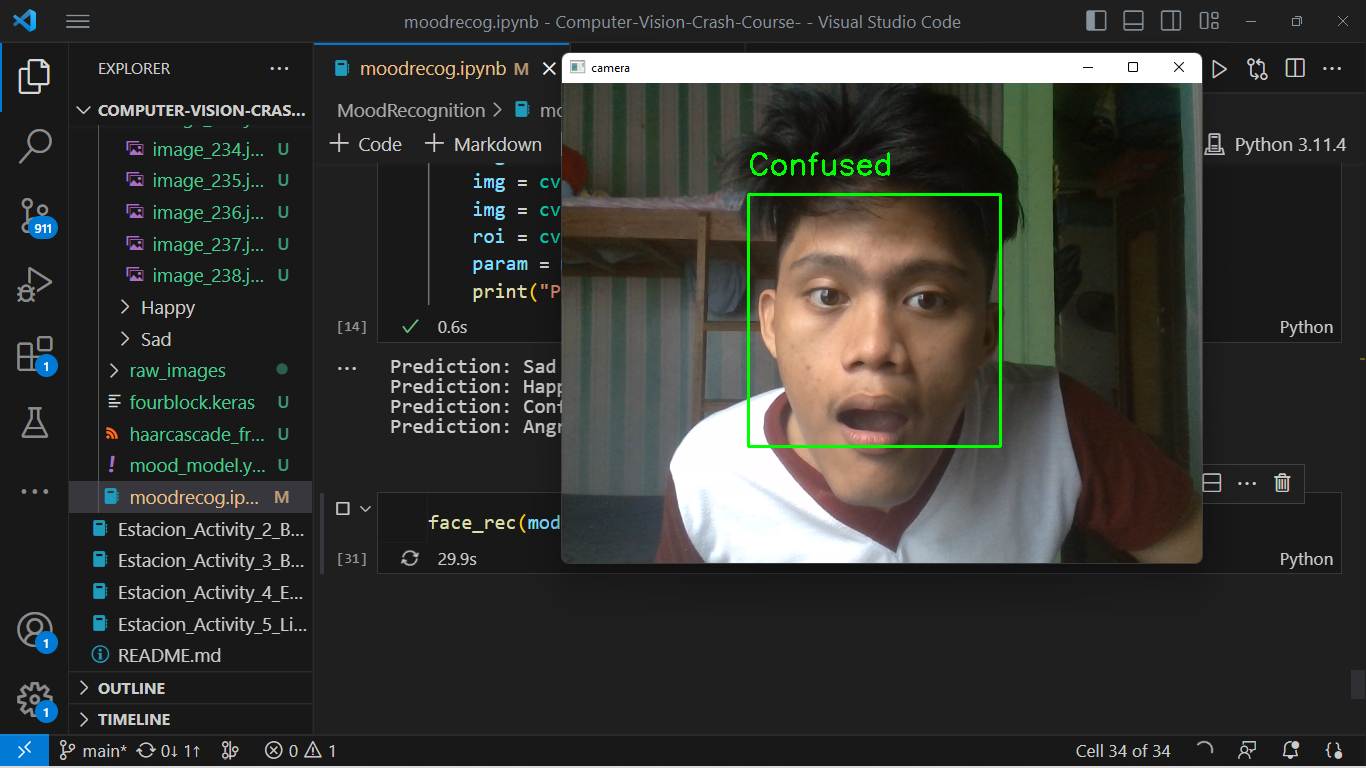

I showed my confused face and it is recognized as confused by the Mood Model. The model is correct.


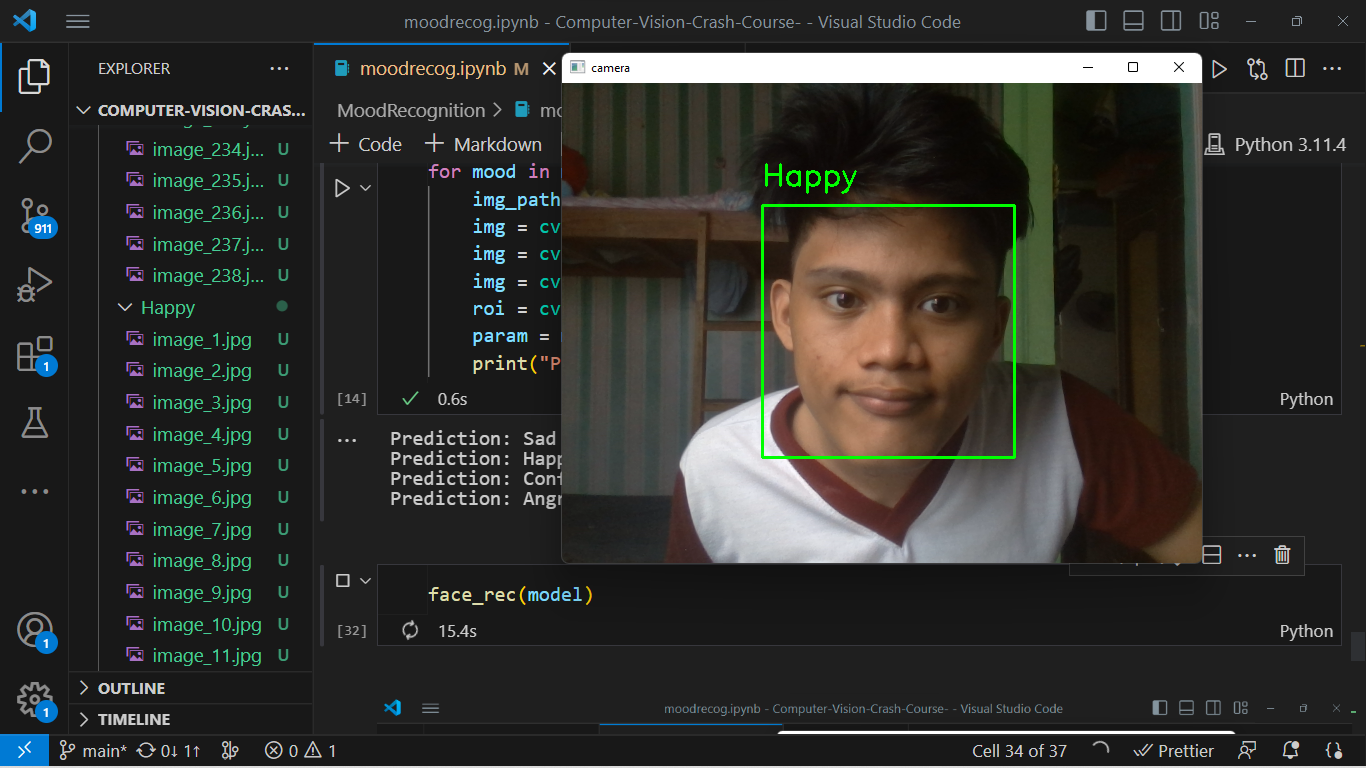

Here is my happy face recognized as happy by the Mood Model. The model is correct.


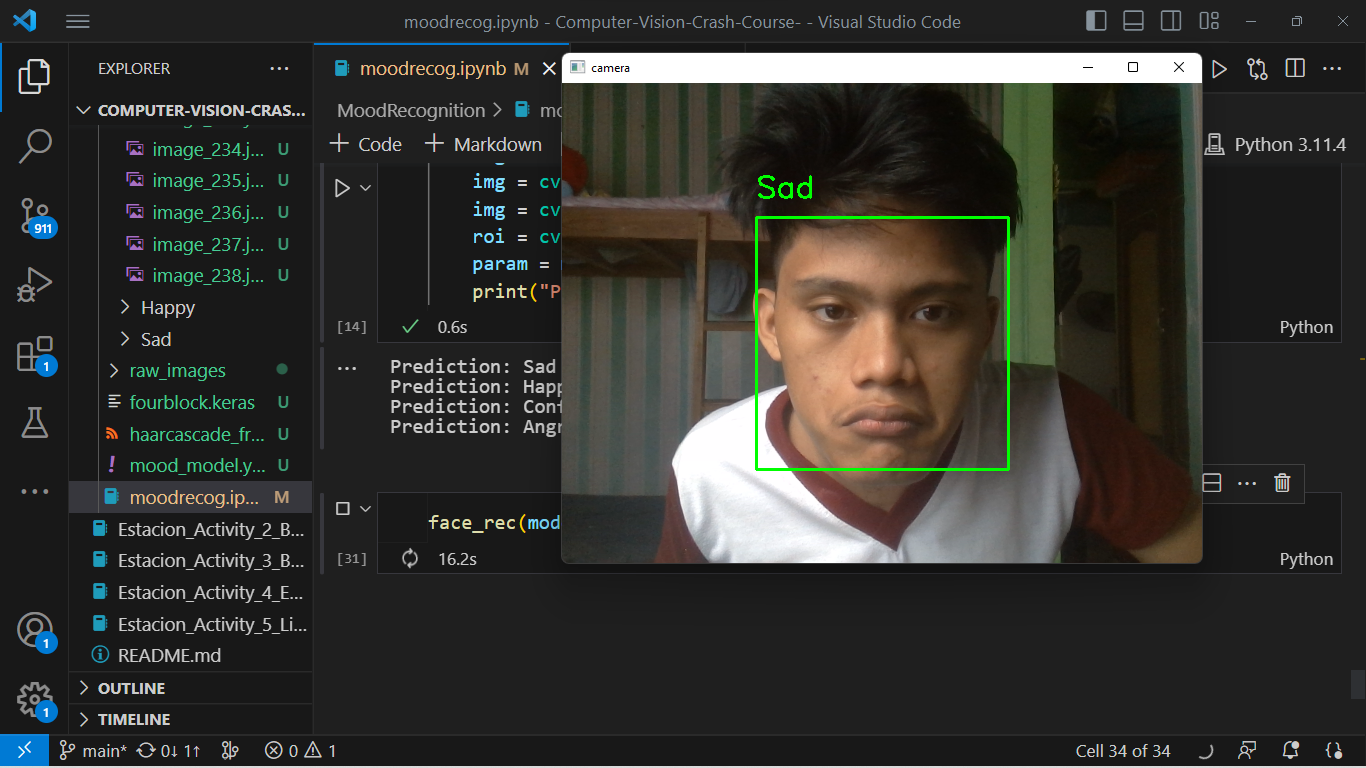

Here is my sad face recognized as sad by the Mood Model. The model is correct.


## Conclusion


I have experienced various issues while creating and testing the models.

These include incorrect shape of training data, unknown directories, and inaccurate model predictions. Incorrect shapes stem from inconsistent resizing of the images so I resized images in training and realtime testing. Additionally, unknown files and directories are solved by recreating the correct structures of the directories and referencing them correctly.

Sometimes, the model cannot predict the sad expression no matter how I frown. Thus, I added another video so the model can learn from it more. After that, the model can detect all four moods of my face.
